In [47]:
from abc import ABC, abstractmethod
import itertools
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import time 


# 4. NVS  

#### 4.1 get the histogram of divisively normalized co-efficients of single frame in a video 

Give the patch size of NXN, and any frame of a video. We first compute the mean and variance for NXN patch corresponding to each pixel location m. We normalised the pixel values based on patch wise mean and variance. i.e. $$\hat{I}(m) = \frac{I(m) - \mu(m)}{\sigma(m)}$$
The corresponding histogram of the normalized co-efficients is matches the gaussian distribution, which can be observed in the output below. 
In order to further improve the stability the gaussian weighted meana and varince are computed which fit the standard gaussian distribution even better. The gaussian weighted mean and variance are computed as follows: $$\mu_{g}(m) = \frac{\sum_{i=1}^{N}w_{i}I_{i}(m)}{\sum_{i=1}^{N}w_{i}}$$ $$\sigma_{g}(m) = \sqrt{\frac{\sum_{i=1}^{N}w_{i}(I_{i}(m) - \mu_{g}(m))^2}{\sum_{i=1}^{N}w_{i}}}$$ 

And the gaussian weighted normalised co-efficients are computed as follows: $$\hat{I}_{g}(m) = \frac{I(m) - \mu_{g}(m)}{\sigma_{g}(m)}$$

In the code below, we write the function for computing the histogram of normalized co-efficients which can take the optional input to use or not use the gaussian weighted mean and variance.

As can be observed from the output below, the normalised frame as very low redudancy and thus help in extracting better image/video scene statistics.


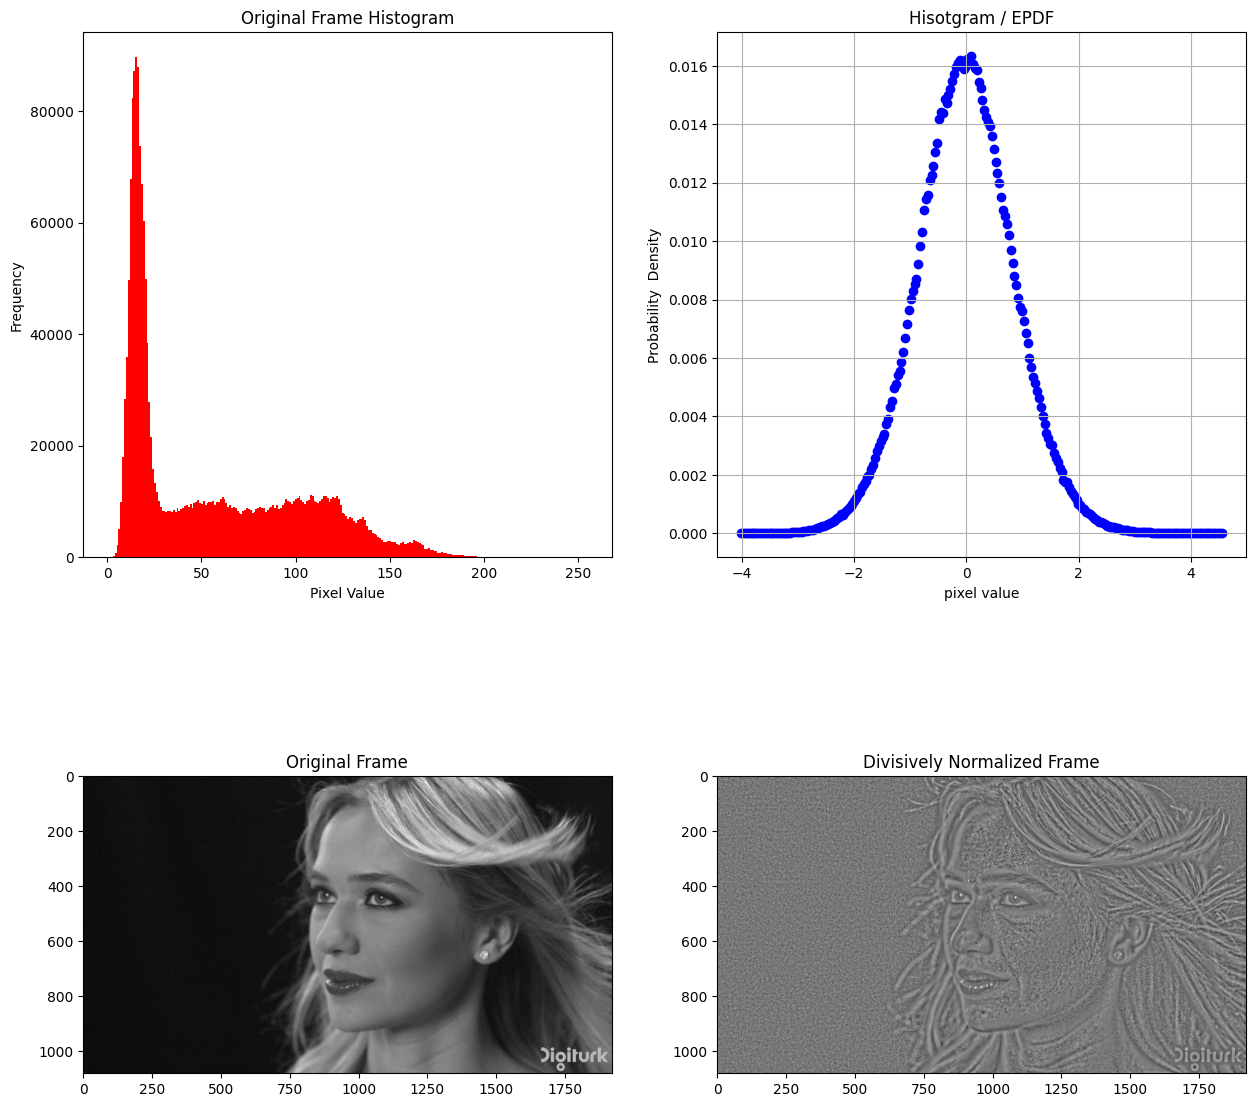

In [54]:

class divisively_normalized_coefficients():
    def __init__(self, filename, height=1080, width=1920, N=15, sigma=5, use_gaussian_kernel=False) -> None:
        """
        Args: 
            filename (str): the path to the yuv file
            height (int): the height of the video
            weight (int): the weight of the video
            N (int): window size
            sigma (float): the sigma of the gaussian kernel
            use_gaussian_kernel (bool): whether to use gaussian kernel or not

        """        
        self.filename = filename
        self.height = height
        self.width = width
        self.N = N
        self.sigma = sigma
        self.use_gaussian_kernel = use_gaussian_kernel
        

    #read the yuv420 file video
    def load_vid_to_frames(self):
        """
        :param filename: the path to the yuv file
        :param height: the height of the video
        :param weight: the weight of the video
        :return: list of frames (flaot32)
        """
        #read the yuv file
        with open(self.filename, 'rb') as f:
            yuv = f.read()
        
        #get the frame size
        frame_size = self.width * self.height * 3 // 2 #yuv420
        
        #get the number of frames
        num_frames = len(yuv) // frame_size
        
        #convert the yuv file to frames
        frames = []
        for i in range(num_frames):
            #get the frame
            frame = yuv[i*frame_size:(i+1)*frame_size]
            
            #convert the frame to rgb
            frame = np.frombuffer(frame, dtype=np.uint8)
            frame = frame.reshape((self.height*3//2, self.width))
            frame = cv2.cvtColor(frame, cv2.COLOR_YUV2RGB_I420)
            
            #add the frame to the list
            frames.append(frame)
        
        return frames

    #patch wise normalization with mean and variance without gaussian kernel
    def patchwise_divisive_norm(self, image):
        """
        Args:   
            image (np.array): the input image
        Returns:
            image (np.array): the normalized image

        """ 
        #image dtype 
        image = image.astype(np.float32)
        # Define the padding size
        pad =self.N // 2
        
        # Create a Gaussian kernel for weighting the pixels
        kernel = cv2.getGaussianKernel(self.N, self.sigma)
        kernel = kernel * kernel.T
        
        # Pad the input image
        padded_image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
        
        if self.use_gaussian_kernel:
            # Calculate the weighted mean and variance of each patch
            patches_mean = cv2.filter2D(padded_image, -1, kernel)[pad:-pad, pad:-pad]
            patches_mean_squared = cv2.filter2D(np.square(padded_image), -1, kernel)[pad:-pad, pad:-pad]
        else: 
            patches_mean = cv2.boxFilter(padded_image, -1, (self.N, self.N))[pad:-pad, pad:-pad]
            patches_mean_squared = cv2.boxFilter(np.square(padded_image), -1, (self.N, self.N))[pad:-pad, pad:-pad]
        patches_var = patches_mean_squared - np.square(patches_mean)

        # Normalize each patch
        patches_norm = (image - patches_mean) / np.sqrt(patches_var + 1e-8)
        
        return patches_norm

    #applying gaussian blur to the frame with sigma
    def gaussian_blur(self,frame, gsigma):
        """ 
        Args:
            frame (np.array): the input frame
            gsigma (float): the sigma of the gaussian kernel
        Returns:
            frame (np.array): the blurred frame
        """
        #apply gaussian blur to the frame
        frame = cv2.GaussianBlur(frame, (self.N, self.N), gsigma)
        return frame


"""
#extract 7z file
import py7zr
with py7zr.SevenZipFile('./Beauty_1920x1080_120fps_420_8bit_YUV_RAW.7z', mode='r') as z:
    z.extractall(path='./')
"""

NVS = divisively_normalized_coefficients(filename='./Beauty_1920x1080_120fps_420_8bit_YUV_RAW/Beauty_1920x1080_120fps_420_8bit_YUV.yuv', height=1080, width=1920, N=25, sigma=5, use_gaussian_kernel=False)
#load the frames
frames = NVS.load_vid_to_frames()

#select any frame
#seed the random number generator 
np.random.seed(10)
rand_int = np.random.randint(0, len(frames))
# Convert the image to grayscale
gray_frame = cv2.cvtColor(frames[rand_int], cv2.COLOR_BGR2GRAY)

# Calculate the divisive normalization coefficient
norm_frame = NVS.patchwise_divisive_norm(gray_frame)

#histogram of the normalized frame; EPDF 
hist, bins = np.histogram(norm_frame.flatten(), bins=256, density=True)
pdf = hist / np.sum(hist)

# Plot the histogram of the normalized frame along with the original frame histogram; add image plot in it. 
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.hist(gray_frame.flatten(), bins=256, range=(0, 255), color='r')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Original Frame Histogram')
plt.subplot(2,2,2)
plt.scatter(bins[:-1], pdf, color='b')
plt.grid()
plt.xlabel('pixel value')
plt.ylabel('Probability  Density')
plt.title('Hisotgram / EPDF')


#plot the normalized frame side by side with the original frame
plt.subplot(2,2,3)
plt.imshow(gray_frame, cmap='gray')
plt.title('Original Frame')
plt.subplot(2,2,4)
plt.imshow(norm_frame, cmap='gray')
plt.title('Divisively Normalized Frame')
plt.show()


### 4.2 Applying cv2.GaussianBlur filter with $\sigma = 2$ in both x and y direction on video. Get the histogram of it using 4.1. Compare the histograms and reason why they are different.

We are applyging the gaussian blur on the image with $\sigma = 2$ in both x and y direction. The output is shown below, a quick comparison of the histogram of the original image and the gaussian blurred image shows that the gaussian blurred image has a much more uniform distribution of the normalized co-efficients. This is because the gaussian blur is a low pass filter which smoothes the image and thus reduces the high frequency components. This is also the reason why the histogram of the gaussian blurred image is more uniform (as we will see in the next part). It is evident as we the gaussian distribution curve getting closer to zero, in the previous plot values went upto and beyond +4/-4 with non-zero probability, whereas in the gaussian blurred image the values are mostly between -3 and 3 with non-zero probability.

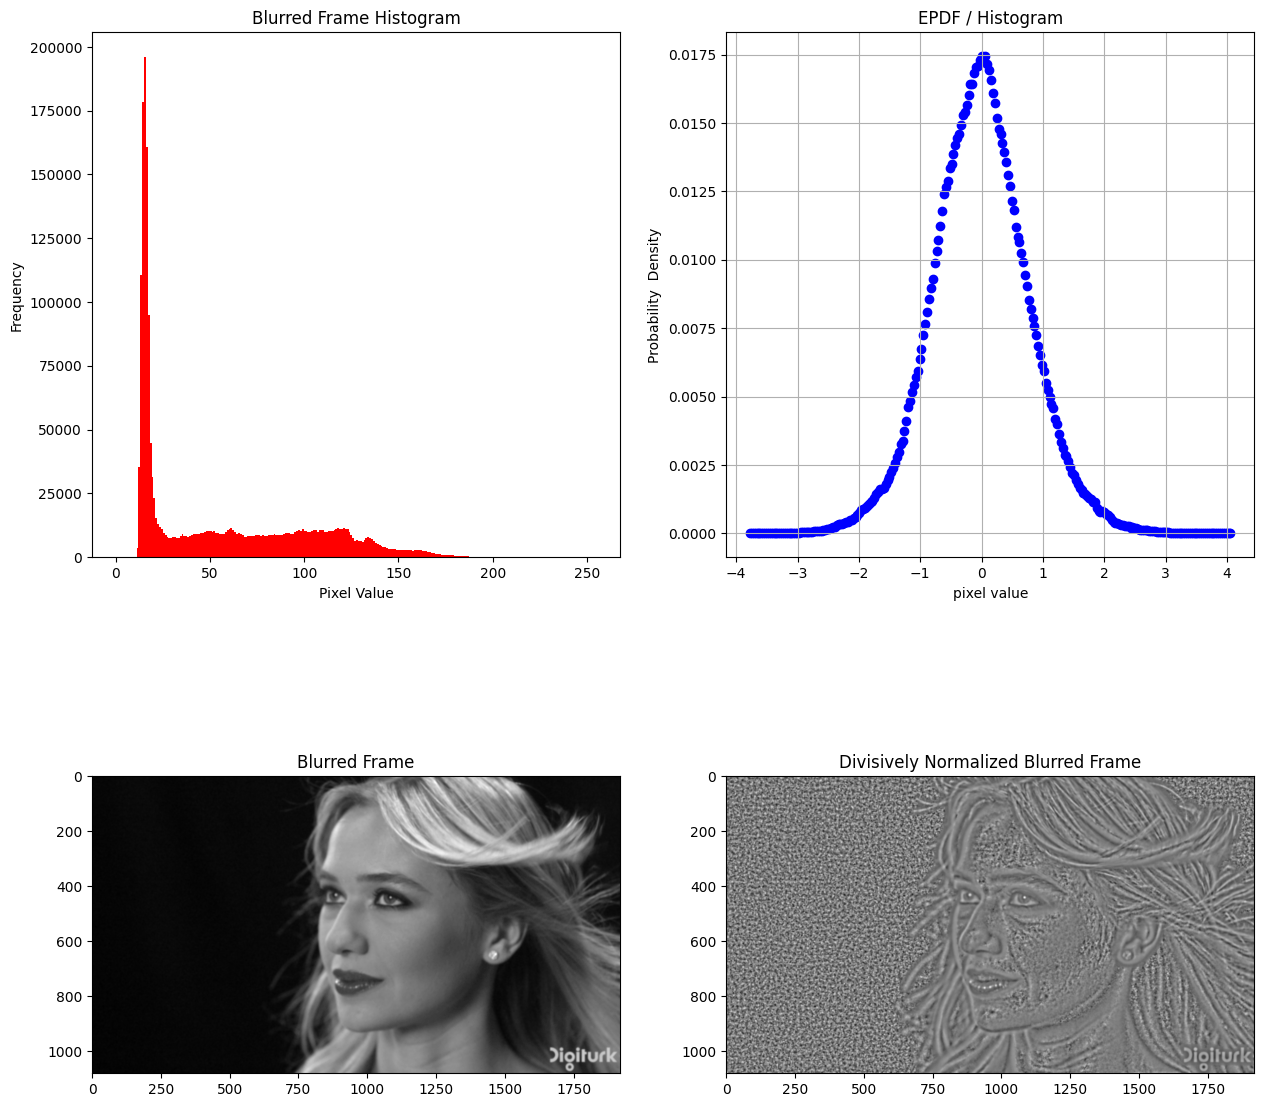

In [55]:
#Getting the blurred frame
blurred_frame = NVS.gaussian_blur(gray_frame, 2)
#divisive normalization of the blurred frame
norm_blurred_frame = NVS.patchwise_divisive_norm(blurred_frame)

#plot the histogram /EPDF 
hist, bins = np.histogram(norm_blurred_frame.flatten(), bins=256, density=True)
pdf = hist / np.sum(hist)

#plot the histogram of the normalized frame along with the original frame histogram; add image plot in it.
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.hist(blurred_frame.flatten(), bins=256, range=(0, 255), color='r')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Blurred Frame Histogram')
plt.subplot(2,2,2)
plt.scatter(bins[:-1], pdf, color='b')
plt.grid()
plt.xlabel('pixel value')
plt.ylabel('Probability  Density')
plt.title('EPDF / Histogram')

#plot the normalized frame side by side with the original frame
plt.subplot(2,2,3)
plt.imshow(blurred_frame, cmap='gray')
plt.title('Blurred Frame')
plt.subplot(2,2,4)
plt.imshow(norm_blurred_frame, cmap='gray')
plt.title('Divisively Normalized Blurred Frame')
plt.show()


### 4.3 Comparison and trend with changing $\sigma$ to 5,10,20. 
As discussed in the previous part, similar pattern is oberseved as we apply the gaussian blur with $\sigma = 5,10,20$. The histogram of the gaussian blurred image is more uniform. We observe here that the gaussian distribution curve is getting closer to zero, with non-zero probability fallying within -2 and 2. Due to the nature of the gaussian blur; It provides as stability i.e. more uniform gaussian distribution and thus better image statistics as discussed in the slides and in lectures. 

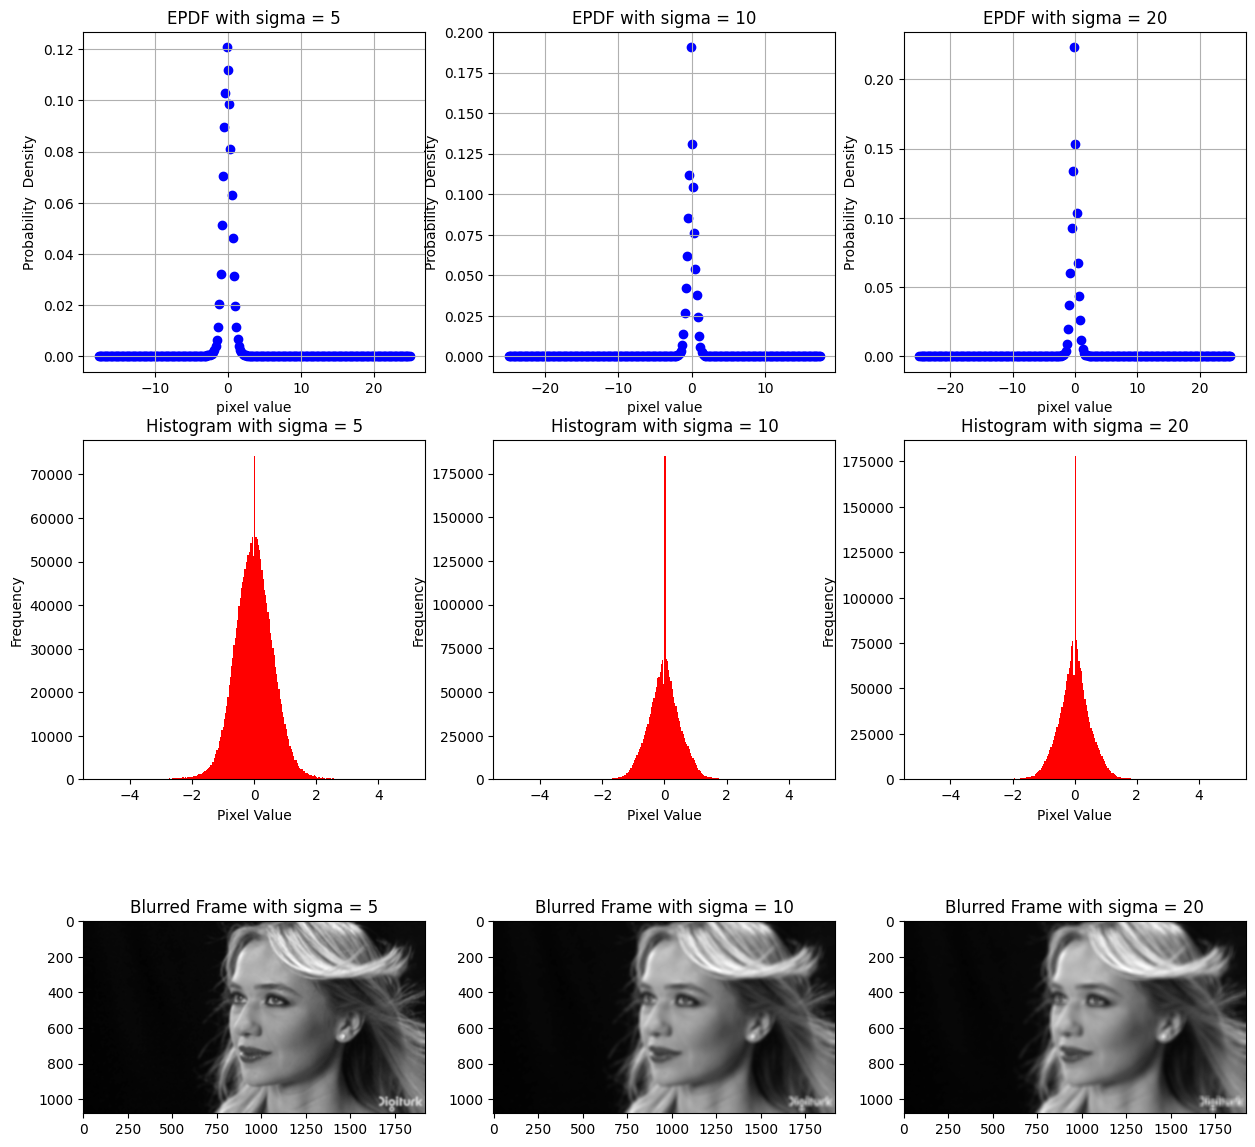

In [56]:
#blurred frame with different sigma
blurred_frame_5 = NVS.gaussian_blur(gray_frame, 5)
blurred_frame_10 = NVS.gaussian_blur(gray_frame, 10)
blurred_frame_20 = NVS.gaussian_blur(gray_frame, 20)

#divisive normalization of the blurred frame
norm_blurred_frame_5 = NVS.patchwise_divisive_norm(blurred_frame_5)
norm_blurred_frame_10 = NVS.patchwise_divisive_norm(blurred_frame_10)
norm_blurred_frame_20 = NVS.patchwise_divisive_norm(blurred_frame_20)

#plot the histogram /EPDF
hist_5, bins_5 = np.histogram(norm_blurred_frame_5.flatten(), bins=256, density=True)
pdf_5 = hist_5 / np.sum(hist_5)

hist_10, bins_10 = np.histogram(norm_blurred_frame_10.flatten(), bins=256, density=True)
pdf_10 = hist_10 / np.sum(hist_10)

hist_20, bins_20 = np.histogram(norm_blurred_frame_20.flatten(), bins=256, density=True)
pdf_20 = hist_20 / np.sum(hist_20)

#plots  
plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plt.scatter(bins_5[:-1], pdf_5, color='b')
plt.grid()
plt.xlabel('pixel value')
plt.ylabel('Probability  Density')
plt.title('EPDF with sigma = 5')

plt.subplot(3,3,2)
plt.scatter(bins_10[:-1], pdf_10, color='b')
plt.grid()
plt.xlabel('pixel value')
plt.ylabel('Probability  Density')
plt.title('EPDF with sigma = 10')

plt.subplot(3,3,3)
plt.scatter(bins_20[:-1], pdf_20, color='b')
plt.grid()
plt.xlabel('pixel value')
plt.ylabel('Probability  Density')
plt.title('EPDF with sigma = 20')

#historgram of the normalized frame 
plt.subplot(3,3,4)
plt.hist(norm_blurred_frame_5.flatten(), bins=256, range=(-5, 5), color='r')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram with sigma = 5')
plt.subplot(3,3,5)
plt.hist(norm_blurred_frame_10.flatten(), bins=256, range=(-5, 5), color='r')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram with sigma = 10')
plt.subplot(3,3,6)
plt.hist(norm_blurred_frame_20.flatten(), bins=256, range=(-5, 5), color='r')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram with sigma = 20')

#blurred frames 
plt.subplot(3,3,7)
plt.imshow(blurred_frame_5, cmap='gray')
plt.title('Blurred Frame with sigma = 5')
plt.subplot(3,3,8)
plt.imshow(blurred_frame_10, cmap='gray')
plt.title('Blurred Frame with sigma = 10')
plt.subplot(3,3,9)
plt.imshow(blurred_frame_20, cmap='gray')
plt.title('Blurred Frame with sigma = 20')
plt.show()


In [57]:
#Save the gray frame for future reference 
cv2.imwrite('Beauty_UVG_frame#{}.jpg'.format(rand_int), gray_frame)

True